# Assignment 2 - Multivariate Gaussian Estimation

### Made by: Syed Bilal Rizwan

In [1]:
#Importing all libraries

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder
import time
from numpy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.feature_selection import SelectKBest, chi2, f_regression
import seaborn as sns
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore')
%load_ext autotime

time: 0 ns (started: 2022-10-16 05:06:32 +05:00)


### 1. Dataset Information
It was a bit difficult to find a dataset that had most of numerical KPIs but then I came across this Russian Housing Dataset that had numerous numeric KPIs. I decided to go with it as it was a housing price prediction problem so regression analysis can be performed and I could estimate the gaussians of them too!


### 2. Sampling and Feature Selection

In [2]:
df = pd.read_csv('train.csv')
df.shape          #Original Shape of the data

(181507, 272)

time: 4.17 s (started: 2022-10-16 05:06:32 +05:00)


Since we need a dataset of less than 20 columns and 100k rows, we will do some feature selection using Random Forest select K best method to select the best 15 features and sample 90000 rows from this dataset:

In [3]:
#Random Sampling technique:

sample_df = df.sample(n = 90000, random_state = 43)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

sample_df = sample_df.select_dtypes(include=numerics)    #This will only keep the numeric columns
X = sample_df.drop(columns = ['price_doc'])
Y = sample_df[['price_doc']]

time: 266 ms (started: 2022-10-16 05:06:36 +05:00)


In [4]:
#Feature Selection Technique:

rf = RandomForestRegressor(random_state=0, n_jobs = -1)
select = SelectKBest(score_func=f_regression, k=15)
select.fit_transform(X,Y)
print(X.columns[(select.get_support())])

Index(['full_sq', 'trc_sqm_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'office_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
       'leisure_count_1000', 'cafe_count_1500_price_high',
       'leisure_count_1500'],
      dtype='object')
time: 188 ms (started: 2022-10-16 05:06:36 +05:00)


In [5]:
X = X[['full_sq', 'trc_sqm_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'office_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
       'leisure_count_1000', 'cafe_count_1500_price_high',
       'leisure_count_1500']]

time: 15 ms (started: 2022-10-16 05:06:37 +05:00)


Now that we have identified 15 best features and taken a sample of 90000 rows, lets have a look at our dataset:

In [6]:
X.head()

,full_sq,trc_sqm_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_4000,cafe_count_500_price_high,mosque_count_500,leisure_count_500,office_sqm_1000,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,leisure_count_1000,cafe_count_1500_price_high,leisure_count_1500
152853,106.02,78800.48,13.52,9.81,1.97,0.32,0.00,0.97,462738.52,22.33,8.84,0.65,4.94,2.97,13.45
169343,93.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
107806,40.50,10200.35,1.50,3.25,0.00,0.00,0.00,0.00,54912.33,3.25,0.00,0.00,0.00,0.00,0.00
167634,65.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1368,1969.03,1410760.14,13.83,1.28,2.80,1.63,0.73,6.76,810047.46,36.72,29.68,4.47,16.18,10.13,22.81


time: 32 ms (started: 2022-10-16 05:06:37 +05:00)


 Now lets do some EDA to see how the distributions of the columns are and whether we can fit a gaussian distribution to them:

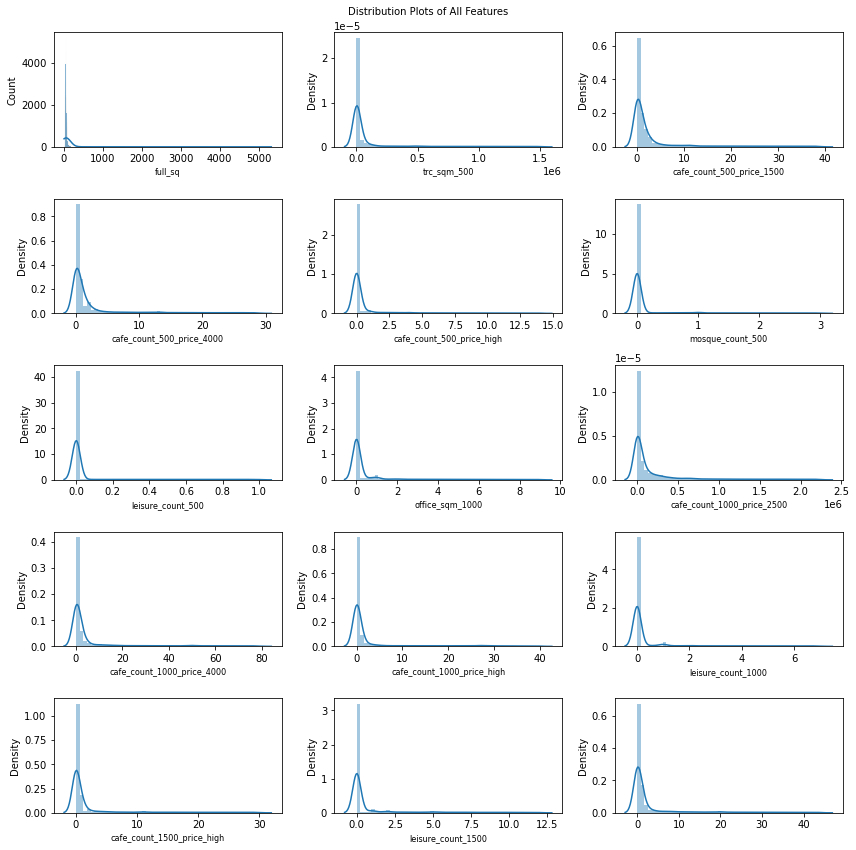

<AxesSubplot:xlabel='price_doc', ylabel='Density'>

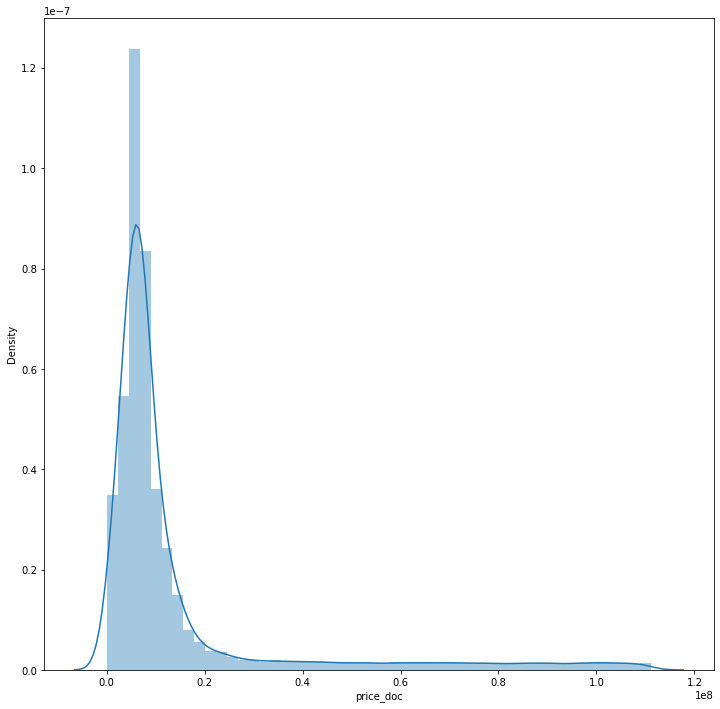

time: 9.56 s (started: 2022-10-16 05:06:37 +05:00)


In [7]:
#A distribution plot is created for each column to see how a normal curve would fit on it:

fig, axes = plt.subplots(5, 3, figsize=(12,12))
fig.suptitle('Distribution Plots of All Features', size=10)

sns.histplot(ax=axes[0,0], x= X["full_sq"], kde=True)
axes[0,0].set_xlabel('full_sq', size=8)

sns.distplot(ax=axes[0,1], x=X["trc_sqm_500"], kde=True)
axes[0,1].set_xlabel('trc_sqm_500', size=8)

sns.distplot(ax=axes[0,2], x=X["cafe_count_500_price_1000"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1000', size=8)

sns.distplot(ax=axes[1,0], x=X["cafe_count_500_price_1500"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1500', size=8)

sns.distplot(ax=axes[1,1], x=X["cafe_count_500_price_4000"], kde=True)
axes[1,0].set_xlabel('cafe_count_500_price_4000', size=8)

sns.distplot(ax=axes[1,2], x=X["cafe_count_500_price_high"], kde=True)
axes[1,1].set_xlabel('cafe_count_500_price_high', size=8)

sns.distplot(ax=axes[2,0], x=X["mosque_count_500"], kde=True)
axes[1,2].set_xlabel('mosque_count_500', size=8)

sns.distplot(ax=axes[2,1], x=X["leisure_count_500"], kde=True)
axes[2,0].set_xlabel('leisure_count_500', size=8)

sns.distplot(ax=axes[2,2], x=X["office_sqm_1000"], kde=True)
axes[2,1].set_xlabel('office_sqm_1000', size=8)

sns.distplot(ax=axes[3,0], x=X["cafe_count_1000_price_2500"], kde=True)
axes[2,2].set_xlabel('cafe_count_1000_price_2500', size=8)

sns.distplot(ax=axes[3,1], x=X["cafe_count_1000_price_4000"], kde=True)
axes[3,0].set_xlabel('cafe_count_1000_price_4000', size=8)

sns.distplot(ax=axes[3,2], x=X["cafe_count_1000_price_high"], kde=True)
axes[3,1].set_xlabel('cafe_count_1000_price_high', size=8)

sns.distplot(ax=axes[4,0], x=X["leisure_count_1000"], kde=True)
axes[3,2].set_xlabel('leisure_count_1000', size=8)

sns.distplot(ax=axes[4,1], x=X["cafe_count_1500_price_high"], kde=True)
axes[4,0].set_xlabel('cafe_count_1500_price_high', size=8)

sns.distplot(ax=axes[4,2], x=X["leisure_count_1500"], kde=True)
axes[4,1].set_xlabel('leisure_count_1500', size=8)


plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(12,12))
axes.set_xlabel('price_doc')
sns.distplot(Y)

As can be seen, the distribution of most of these columns follow a half gaussian distribution centered around 0 and can be estimated to be normally distributed

### 3. Machine Learning Pipeline 1 (Original Dataset)

In [8]:
#lets split the data into a train test split from the start, test set will be kept separate and will only be used for testing purposes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state =43)  


time: 16 ms (started: 2022-10-16 05:06:46 +05:00)


In [9]:
# Lazy Regressor is used to run all the regression algorithms and get their metric. This will help us compare later on:

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [21:43<00:00, 31.05s/it]

                               Adjusted R-Squared  R-Squared        RMSE  \
Model                                                                      
ExtraTreesRegressor                          0.65       0.65 12786441.56   
RandomForestRegressor                        0.65       0.65 12791376.53   
HistGradientBoostingRegressor                0.65       0.65 12851170.81   
GradientBoostingRegressor                    0.65       0.65 12883026.37   
LGBMRegressor                                0.64       0.65 12945928.97   
AdaBoostRegressor                            0.64       0.64 13059208.92   
BaggingRegressor                             0.62       0.62 13331656.35   
XGBRegressor                                 0.61       0.61 13503519.18   
LassoCV                                      0.60       0.60 13787100.82   
LarsCV                                       0.60       0.60 13787106.68   
LassoLarsCV                                  0.60       0.60 13787106.68   
LassoLars   

The best R-squared is computed to be 0.65 so we can keep this as a standard to compare with our sampled dataset.

### 4. Estimating Multivariate Gaussian

###### Note: I have estimated a single joint Multivariate Gaussian for this problem, I was able to successfully do that!

#### 4.1 Using OOP to create own class for parameter estimation:

To estimate the gaussian mixture parameters, we need mean vector of features and covariance matrix. At first, for practice purpose, a method was built from scratch to compute the gaussian mixture parameters as shown below:

First all the variables including the target one are combined so that a multivariate gaussian can be fit on the entire data, this will be the first approach where we include Target Variable Y


In [10]:
df_new = pd.concat([X_train,y_train], axis = 1)

time: 16 ms (started: 2022-10-16 05:28:30 +05:00)


In [11]:
# A class was created to fit a multivariate gaussian to a given dataset:

class MultivariateNormal(object):
    def __init__(self):
        self.u = None
        self.sig = None
    
    @staticmethod
    def redimx(x):
        return  x[..., np.newaxis] if x.ndim ==2 else x
        
    def fit(self, x):
        x = self.redimx(x)
        self.u_ = x.mean(0)  # Returns Mean Vector
        self.sig_ = np.einsum('ijk, ikj->jk', x-self.u_, x-self.u_)/(x.shape[0]-1)   #Returns Covariance Matrix
        
    def prob(self, x): #Returns probability of X happening after paramters have been fit
        x = self.redimx(x)

        factor1 = (2*np.pi)**(-self.u_.shape[0]/2)*np.linalg.det(self.sig_)**(-1/2)
        factor2 = np.exp((-1/2)*np.einsum('ijk,jl,ilk->ik', x-self.u_, np.linalg.inv(self.sig_), x-self.u_))  
        return factor1 * factor2

time: 0 ns (started: 2022-10-16 05:28:30 +05:00)


Now lets estimate the paramaters:

In [12]:
df_new_array = df_new.to_numpy()
model = MultivariateNormal()   #MultivariateNormal object is initialized
model.fit(df_new_array)        #Data is fit to the model and parameters are estimated 
means = model.u_               #Extracts the mean vector of columns
sds = model.sig_               #Extracts the covariance matrix 
mean_list = means.tolist()     
mean_flat_list = []            
for sublist in mean_list:      #A intermediary step
    for num in sublist:
        mean_flat_list.append(num)


time: 32 ms (started: 2022-10-16 05:28:30 +05:00)


After estimating the parameters, we can sample the data from our fitted gaussian mixture by using the numpy random method "Multivariate_normal" by giving the mean vector, covariance matrix and size of sample needed:

In [13]:
sampled_x = np.random.multivariate_normal(mean_flat_list, sds, size = 67500)
gauss_sampled_df = pd.DataFrame(sampled_x , columns = ['full_sq', 'trc_sqm_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'office_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
       'leisure_count_1000', 'cafe_count_1500_price_high',
       'leisure_count_1500', 'price_doc'])
gauss_sampled_df.head()

,full_sq,trc_sqm_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_4000,cafe_count_500_price_high,mosque_count_500,leisure_count_500,office_sqm_1000,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,leisure_count_1000,cafe_count_1500_price_high,leisure_count_1500,price_doc
0,266.42,-365632.66,2.00,0.83,0.04,-0.85,-0.23,-0.07,88368.46,-3.45,-8.78,1.35,-0.40,1.55,-0.90,5453874.26
1,2328.53,586076.15,14.35,11.99,5.52,0.96,0.51,4.40,1072495.52,33.72,11.23,2.35,15.73,7.23,24.54,44957323.49
2,176.60,246391.20,-1.45,-1.10,-0.65,0.37,0.10,0.90,138277.89,-5.18,-1.90,0.64,-1.13,-0.23,0.16,-743022.53
3,958.29,-204402.91,-2.74,0.41,3.33,0.35,0.07,-0.59,-243041.78,-2.49,7.70,0.11,-5.17,1.98,1.38,13337170.68
4,-399.68,-150248.61,-4.07,-0.36,0.01,0.19,-0.10,-3.14,58990.08,-6.74,-4.00,0.13,-4.54,0.31,-3.52,-17250865.35


time: 31 ms (started: 2022-10-16 05:28:30 +05:00)


We can plot the newly created sample data as shown below:

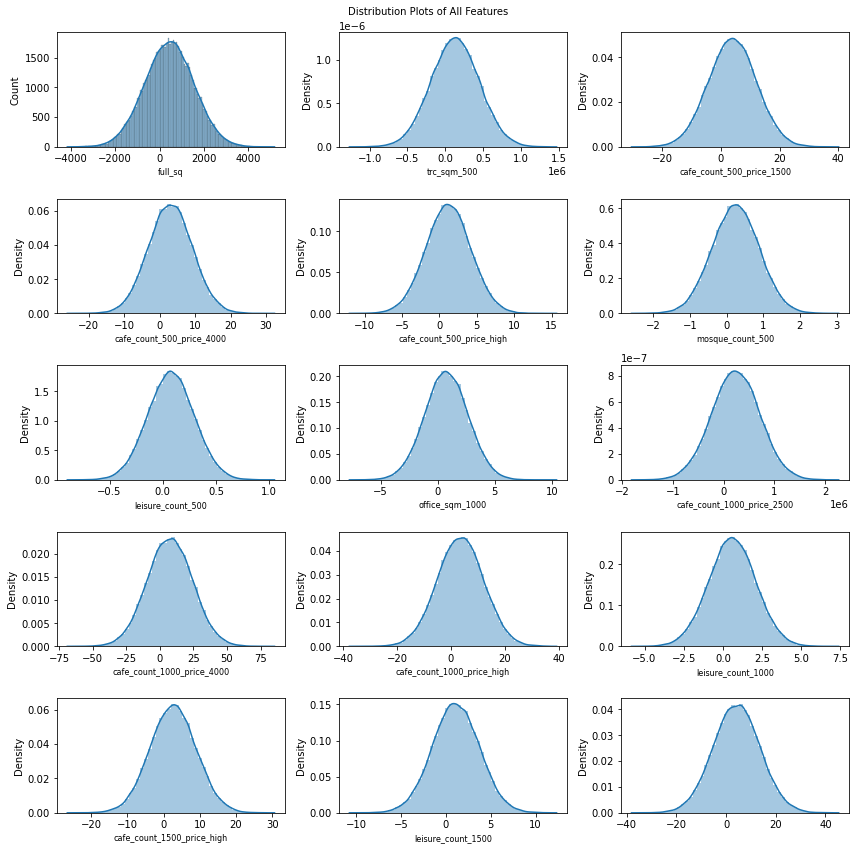

<AxesSubplot:xlabel='price_doc', ylabel='Density'>

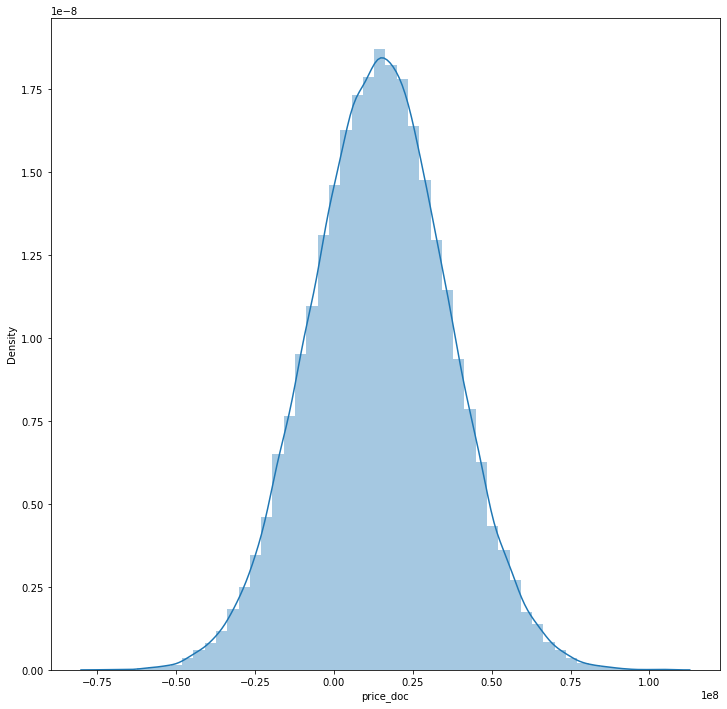

time: 5.89 s (started: 2022-10-16 05:28:30 +05:00)


In [14]:
fig, axes = plt.subplots(5, 3, figsize=(12,12))
fig.suptitle('Distribution Plots of All Features', size=10)

sns.histplot(ax=axes[0,0], x= gauss_sampled_df["full_sq"], kde=True)
axes[0,0].set_xlabel('full_sq', size=8)

sns.distplot(ax=axes[0,1], x=gauss_sampled_df["trc_sqm_500"], kde=True)
axes[0,1].set_xlabel('trc_sqm_500', size=8)

sns.distplot(ax=axes[0,2], x=gauss_sampled_df["cafe_count_500_price_1000"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1000', size=8)

sns.distplot(ax=axes[1,0], x=gauss_sampled_df["cafe_count_500_price_1500"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1500', size=8)

sns.distplot(ax=axes[1,1], x=gauss_sampled_df["cafe_count_500_price_4000"], kde=True)
axes[1,0].set_xlabel('cafe_count_500_price_4000', size=8)

sns.distplot(ax=axes[1,2], x=gauss_sampled_df["cafe_count_500_price_high"], kde=True)
axes[1,1].set_xlabel('cafe_count_500_price_high', size=8)

sns.distplot(ax=axes[2,0], x=gauss_sampled_df["mosque_count_500"], kde=True)
axes[1,2].set_xlabel('mosque_count_500', size=8)

sns.distplot(ax=axes[2,1], x=gauss_sampled_df["leisure_count_500"], kde=True)
axes[2,0].set_xlabel('leisure_count_500', size=8)

sns.distplot(ax=axes[2,2], x=gauss_sampled_df["office_sqm_1000"], kde=True)
axes[2,1].set_xlabel('office_sqm_1000', size=8)

sns.distplot(ax=axes[3,0], x=gauss_sampled_df["cafe_count_1000_price_2500"], kde=True)
axes[2,2].set_xlabel('cafe_count_1000_price_2500', size=8)

sns.distplot(ax=axes[3,1], x=gauss_sampled_df["cafe_count_1000_price_4000"], kde=True)
axes[3,0].set_xlabel('cafe_count_1000_price_4000', size=8)

sns.distplot(ax=axes[3,2], x=gauss_sampled_df["cafe_count_1000_price_high"], kde=True)
axes[3,1].set_xlabel('cafe_count_1000_price_high', size=8)

sns.distplot(ax=axes[4,0], x=gauss_sampled_df["leisure_count_1000"], kde=True)
axes[3,2].set_xlabel('leisure_count_1000', size=8)

sns.distplot(ax=axes[4,1], x=gauss_sampled_df["cafe_count_1500_price_high"], kde=True)
axes[4,0].set_xlabel('cafe_count_1500_price_high', size=8)

sns.distplot(ax=axes[4,2], x=gauss_sampled_df["leisure_count_1500"], kde=True)
axes[4,1].set_xlabel('leisure_count_1500', size=8)



plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(12,12))
axes.set_xlabel('price_doc')
sns.distplot(gauss_sampled_df["price_doc"])

##### 4.1.1 Machine Learning Pipeline 2 (Using own gaussian mixture fitting)

As we can see, a very smooth normal distribution is estimated here for each feature of ours. It can prove to be bad for us since most of our columns were right skewed and we are forcing it to be a perfect gaussian distribution. Now lets run the ML pipeline again to compare the results:

In [15]:
x_sampled_df = gauss_sampled_df.drop(columns = ['price_doc'])
y_sampled_df = gauss_sampled_df[['price_doc']]
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(x_sampled_df, X_test, y_sampled_df, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [19:11<00:00, 27.41s/it]

                               Adjusted R-Squared  R-Squared        RMSE  \
Model                                                                      
Lasso                                        0.60       0.60 13788529.81   
LassoLarsCV                                  0.60       0.60 13788529.88   
LinearRegression                             0.60       0.60 13788529.88   
LarsCV                                       0.60       0.60 13788529.88   
Lars                                         0.60       0.60 13788529.88   
LassoLarsIC                                  0.60       0.60 13788529.88   
TransformedTargetRegressor                   0.60       0.60 13788529.88   
Ridge                                        0.60       0.60 13788530.34   
LassoLars                                    0.60       0.60 13788530.46   
RidgeCV                                      0.60       0.60 13788534.45   
BayesianRidge                                0.60       0.60 13788569.89   
LassoCV     

#####  4.1.2 Discussion
The results seem quite well given that our R2 score only decreased slightly from 0.65 to 0.60 after generating data from a fitted gaussian distribution.

##### 4.2 Using Gaussian Mixture Method in Sci-kit Learn

A second method to sample from a fitted gaussian mixture is to simply use a GaussianMixture method from Sklearn. It is a very handy and good method as it fit the parameters itself and use it to give you samples as shown below:
    

In [16]:
gm = GaussianMixture (n_components = 16, random_state = 43) #This function initializes our GaussianMixutre moel
gm.fit(df_new) #This will fit our data to the gaussian mixture model
new_gm_sample = gm.sample(n_samples = 75000)[0]  #This will sample data from the gaussian mixture learned from previous line
GMM_sampled_df = pd.DataFrame(new_gm_sample , columns = ['full_sq', 'trc_sqm_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'office_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
       'leisure_count_1000', 'cafe_count_1500_price_high',
       'leisure_count_1500', 'price_doc'])

time: 11.5 s (started: 2022-10-16 05:47:48 +05:00)


Now lets try plotting the generated columns and see how their distributions seems like:

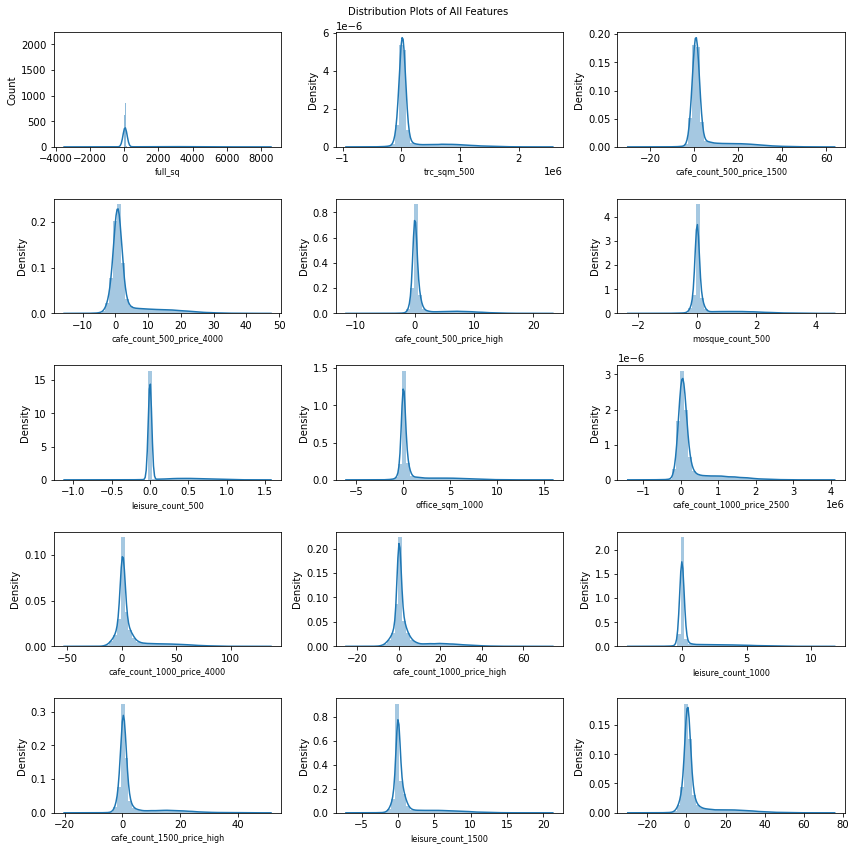

<AxesSubplot:xlabel='price_doc', ylabel='Density'>

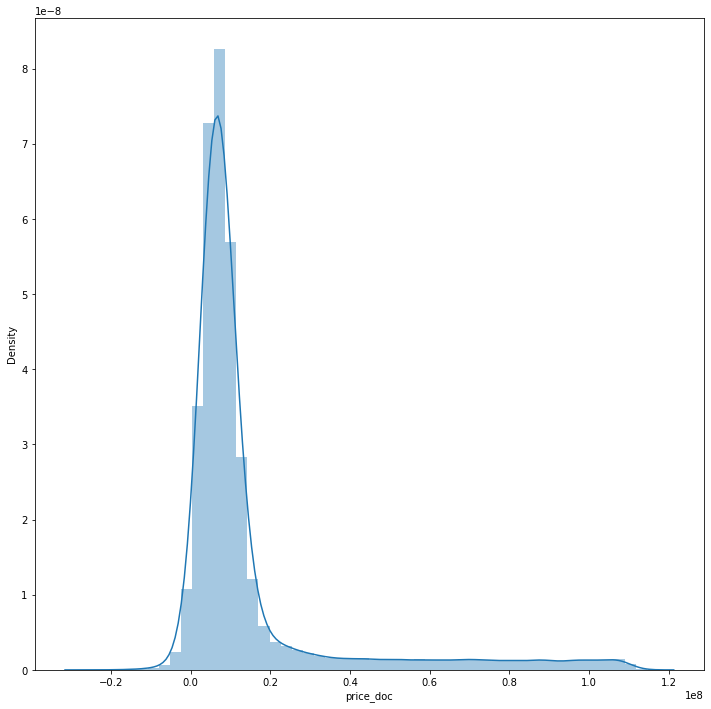

time: 13.3 s (started: 2022-10-16 05:47:59 +05:00)


In [17]:

fig, axes = plt.subplots(5, 3, figsize=(12,12))
fig.suptitle('Distribution Plots of All Features', size=10)

sns.histplot(ax=axes[0,0], x= GMM_sampled_df["full_sq"], kde=True)
axes[0,0].set_xlabel('full_sq', size=8)

sns.distplot(ax=axes[0,1], x=GMM_sampled_df["trc_sqm_500"], kde=True)
axes[0,1].set_xlabel('trc_sqm_500', size=8)

sns.distplot(ax=axes[0,2], x=GMM_sampled_df["cafe_count_500_price_1000"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1000', size=8)

sns.distplot(ax=axes[1,0], x=GMM_sampled_df["cafe_count_500_price_1500"], kde=True)
axes[0,2].set_xlabel('cafe_count_500_price_1500', size=8)

sns.distplot(ax=axes[1,1], x=GMM_sampled_df["cafe_count_500_price_4000"], kde=True)
axes[1,0].set_xlabel('cafe_count_500_price_4000', size=8)

sns.distplot(ax=axes[1,2], x=GMM_sampled_df["cafe_count_500_price_high"], kde=True)
axes[1,1].set_xlabel('cafe_count_500_price_high', size=8)

sns.distplot(ax=axes[2,0], x=GMM_sampled_df["mosque_count_500"], kde=True)
axes[1,2].set_xlabel('mosque_count_500', size=8)

sns.distplot(ax=axes[2,1], x=GMM_sampled_df["leisure_count_500"], kde=True)
axes[2,0].set_xlabel('leisure_count_500', size=8)

sns.distplot(ax=axes[2,2], x=GMM_sampled_df["office_sqm_1000"], kde=True)
axes[2,1].set_xlabel('office_sqm_1000', size=8)

sns.distplot(ax=axes[3,0], x=GMM_sampled_df["cafe_count_1000_price_2500"], kde=True)
axes[2,2].set_xlabel('cafe_count_1000_price_2500', size=8)

sns.distplot(ax=axes[3,1], x=GMM_sampled_df["cafe_count_1000_price_4000"], kde=True)
axes[3,0].set_xlabel('cafe_count_1000_price_4000', size=8)

sns.distplot(ax=axes[3,2], x=GMM_sampled_df["cafe_count_1000_price_high"], kde=True)
axes[3,1].set_xlabel('cafe_count_1000_price_high', size=8)

sns.distplot(ax=axes[4,0], x=GMM_sampled_df["leisure_count_1000"], kde=True)
axes[3,2].set_xlabel('leisure_count_1000', size=8)

sns.distplot(ax=axes[4,1], x=GMM_sampled_df["cafe_count_1500_price_high"], kde=True)
axes[4,0].set_xlabel('cafe_count_1500_price_high', size=8)

sns.distplot(ax=axes[4,2], x=GMM_sampled_df["leisure_count_1500"], kde=True)
axes[4,1].set_xlabel('leisure_count_1500', size=8)


plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(12,12))
axes.set_xlabel('price_doc')
sns.distplot(GMM_sampled_df["price_doc"])

As seen from the curves above, the normal curve seems more appropriately fit using the sklearn's method. Now, the right skewedness of the columns are also captured so we can expect our ML metrics to perform more closer to the original dataset than the previous iteration. Now lets try running the ML pipeline again to see how it differs from the previous two ones:

##### 4.2.1 Machine Learning Pipeline 3 - (Using Sci-kit Learn's Gaussian mixture fitting)

In [18]:
x_sampled_df = GMM_sampled_df.drop(columns = ['price_doc'])
y_sampled_df = GMM_sampled_df[['price_doc']]

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(x_sampled_df, X_test, y_sampled_df, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [27:12<00:00, 38.87s/it]

                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
HistGradientBoostingRegressor                0.63       0.63  13186768.85   
GradientBoostingRegressor                    0.63       0.63  13212118.95   
AdaBoostRegressor                            0.62       0.62  13316624.15   
ExtraTreesRegressor                          0.62       0.62  13342243.22   
RandomForestRegressor                        0.62       0.62  13343513.14   
LGBMRegressor                                0.62       0.62  13435348.02   
XGBRegressor                                 0.60       0.60  13795844.81   
BayesianRidge                                0.60       0.60  13798346.27   
LassoLars                                    0.60       0.60  13798352.30   
RidgeCV                                      0.60       0.60  13798389.65   
Ridge                                        0.60       0.60  13798395.19   

###### 4.2.2 Discussion
Using GMM (Sci-kit Learn's own method) instead of my own helped close the gap between testing R2 score of original dataset and newly generated one. The R2 score decreased from 0.65 to 0.63 which is amazing. It shows that our estimation of gaussian mixture parameters is on point and it can be used to generate more data like our original one and we have found an parameters that estimate the population space of our original dataset.

####  4.3 Fitting Gaussian mixture on only independent variables

As can be seen, the GMM model of sci-kit learn is performing slightly compared to self-made gaussian fitting so, I will use GMM for the 4th iteration where I will not include the dependent variable in estimation of gaussian mixture. The dependent variable will remain as y_train from original dataset and newly sampled columns will only be the independent variables. I want to see if including dependent variable in gaussian mixture is important or not. 

In [19]:
gm = GaussianMixture (n_components = 15, random_state = 43) #This function initializes our GaussianMixutre moel
gm.fit(X_train) #This will fit our data to the gaussian mixture model
new_gm_sample = gm.sample(n_samples = 67500)[0]  #This will sample data from the gaussian mixture learned from previous line
GMM_sampled_df = pd.DataFrame(new_gm_sample , columns = ['full_sq', 'trc_sqm_500', 'cafe_count_500_price_1000',
       'cafe_count_500_price_1500', 'cafe_count_500_price_4000',
       'cafe_count_500_price_high', 'mosque_count_500', 'leisure_count_500',
       'office_sqm_1000', 'cafe_count_1000_price_2500',
       'cafe_count_1000_price_4000', 'cafe_count_1000_price_high',
       'leisure_count_1000', 'cafe_count_1500_price_high',
       'leisure_count_1500'])


time: 6.11 s (started: 2022-10-16 06:15:25 +05:00)


##### 4.3.1 Machine Learning Pipeline 4 (Sampled only independent variables):


In [20]:
x_sampled_df = GMM_sampled_df
y_sampled_df = y_train

clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(x_sampled_df, X_test, y_sampled_df, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [21:02<00:00, 30.06s/it]

                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
ExtraTreesRegressor                          0.06       0.06  21074169.08   
SGDRegressor                                 0.02       0.02  21495126.84   
XGBRegressor                                 0.01       0.01  21601594.37   
LGBMRegressor                                0.00       0.01  21672365.77   
RandomForestRegressor                        0.00       0.00  21681851.42   
HistGradientBoostingRegressor                0.00       0.00  21694157.80   
GradientBoostingRegressor                    0.00       0.00  21705664.99   
LassoLarsIC                                 -0.00      -0.00  21730141.51   
LassoCV                                     -0.00      -0.00  21730141.51   
LarsCV                                      -0.00      -0.00  21730141.51   
LassoLarsCV                                 -0.00      -0.00  21730141.51   

##### 4.3.2 Discussion
It can be seen that removing dependent variable "Y" when fitting a gaussian mixture on our data very badly affects our prediction capabilities and it makes sense too. If we are excluding our dependent variable, we are not considering its Covariance with other columns when estimating the gaussian hence we are eliminating our data's mapping of independent variables to dependent variables. This is why our generated data becomes random and bogus until we capture the interactions between the independent and dependent variable. 

### 5. Conclusion

Gaussian Mixture model of sklearn performed best in estimating the multivariate gaussian of my entire dataset. The difference in R2 scores is insignificant around 4.6%. It shows that if we learn a single multivariate gaussian for our original data, we can run our ML pipelines on sampled data from the multivariate gaussian space and it will not affect our Machine learning performances. In short, our hypothesis is correct that ML performances will not be affected if a correct Multivariate gaussian is estimated and our models are trained from sampled data rather than original one.

Furthermore, it will help us in generating more data containing the patterns our original data has so more data can always be sampled and we can run ML techniques that require large data such as neural network more efficiently.

In addition, the parameter estimation for our joint gaussian include Covariance Matrix and mean vector, once we have fitted our data onto these parameters, we found out the population space in which this original data existed. This is a very powerful concept showing that we have cracked the case in figuring out the parameters that governs our population space of the data. 

However, the one drawback of estimating a joint gaussian and using it to train our models is that we lose the meaning of our data. For example the house prices column were supposed to be all non-negative large values but after sampling from our random distribution, some of them were negative and the distribution was centered around zero. So, the newly generated samples can definitely be used in training our models but we cannot interpret what they mean by looking at their values as their values have been transformed into just numbers between -ve and +ve. Later on, I tried to replace the values that are negative to zero but it affected the ML performance greatly. So, care must be taken not to start devising meaning from sampled data but only use it for ML training purposes as the meanings are only reduced to probability densities.
